## Churn Prediction

### Use a dataset of customer information and build a model that can predict which customers are most likely to leave a company

# Importing Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [48]:
# Reading dataset
df= pd.read_csv("/content/customer_churn.csv")
pd.set_option('display.max_columns',None)
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

## Data Preprocessing & Visualisation

In [49]:
# Checking null values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [51]:
# Handling 'TotalCharges' column
df['TotalCharges'].value_counts()

,count
TotalCharges,
,11
20.2,11
19.75,9
20.05,8
19.9,8
...,...
130.15,1
3211.9,1
7843.55,1


In [52]:
# We can see from the value_counts that there is an empty string
# Finding the mean leaving out the missing string
TotalCharges_mean = df[df['TotalCharges']!=' ']['TotalCharges'].astype('float').mean()
TotalCharges_mean = round(TotalCharges_mean, 2)
# Replacing the missing string with mean
df['TotalCharges']=df['TotalCharges'].replace(' ', TotalCharges_mean)

In [53]:
# Converting the "TotalCharges" to float type
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [54]:
# Dropping unnecessary column
df.drop('customerID', axis=1, inplace= True)

In [55]:
# Making 'SeniorCitizen' column object type for visiualization
df['SeniorCitizen']= df['SeniorCitizen'].astype('object')

In [56]:
categorical_columns = df.select_dtypes(include='object').columns.tolist()
numerical_columns = df.select_dtypes(exclude='object').columns.tolist()

/tmp/ipython-input-967834103.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, ax=axes[i], palette=color_palette)
/tmp/ipython-input-967834103.py:18: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data=df, x=column, ax=axes[i], palette=color_palette)
/tmp/ipython-input-967834103.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, ax=axes[i], palette=color_palette)
/tmp/ipython-input-967834103.py:18: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data=df, x=column, ax=axes[i], palette=color_palette)
/tmp/ipython-input-9

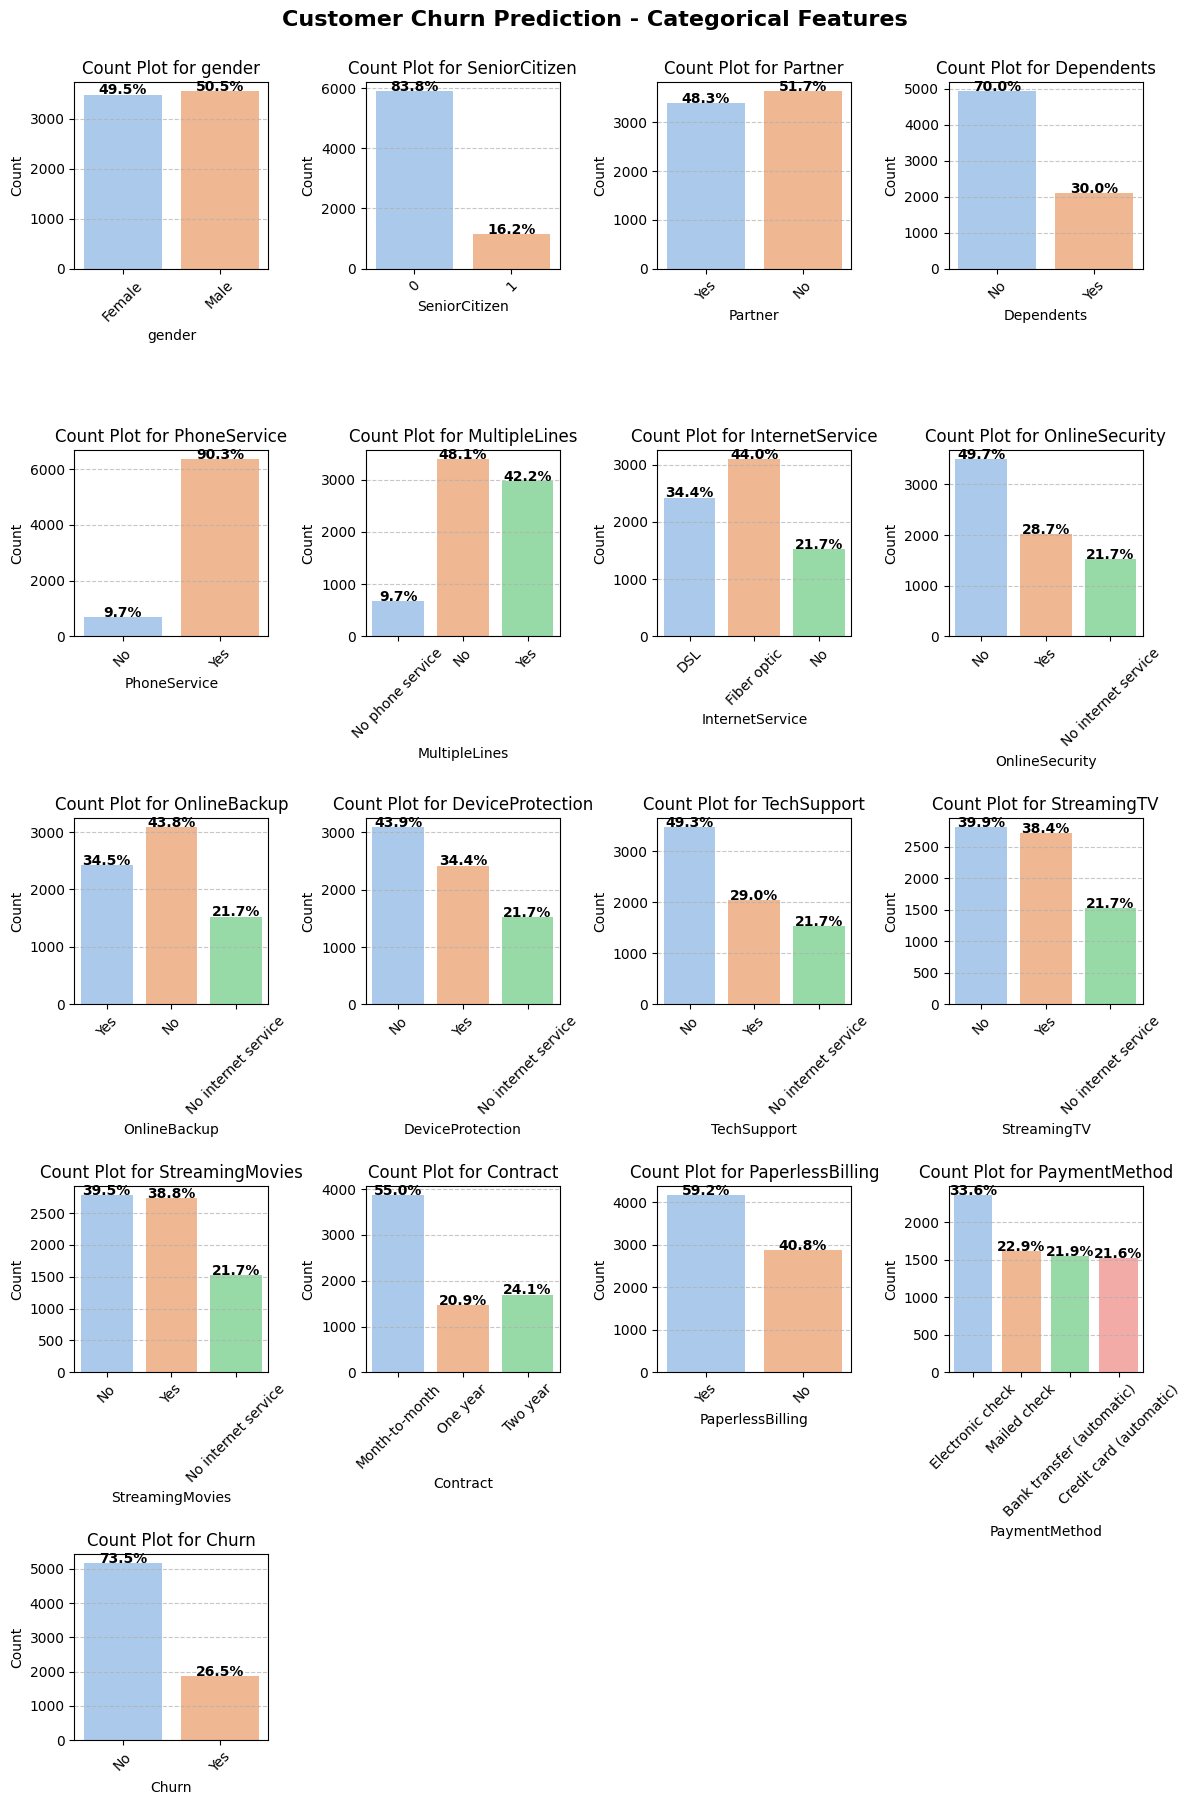

In [57]:
# Visualising countplots for all object type columns

# Setting the number of rows and columns for subplots
num_rows = 5
num_cols = (len(categorical_columns) + num_rows - 1) // num_rows

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 18))

# Flatten axes if necessary
axes = axes.flatten()

# Custom color palette
color_palette = sns.color_palette("pastel")

# Loop through object columns and create count plots
for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, x=column, ax=axes[i], palette=color_palette)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f"Count Plot for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

    # Adding percentage labels
    total_count = len(df[column])
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].text(p.get_x() + p.get_width() / 2., height + 5, f'{height / total_count:.1%}',
                     ha="center", fontsize=10, fontweight='bold')

# Hiding the extra subplots if any
for j in range(len(categorical_columns), num_rows * num_cols):
    axes[j].axis('off')

plt.suptitle("Customer Churn Prediction - Categorical Features", fontsize=16, y=1.00, fontweight='bold')
plt.tight_layout()
plt.show()

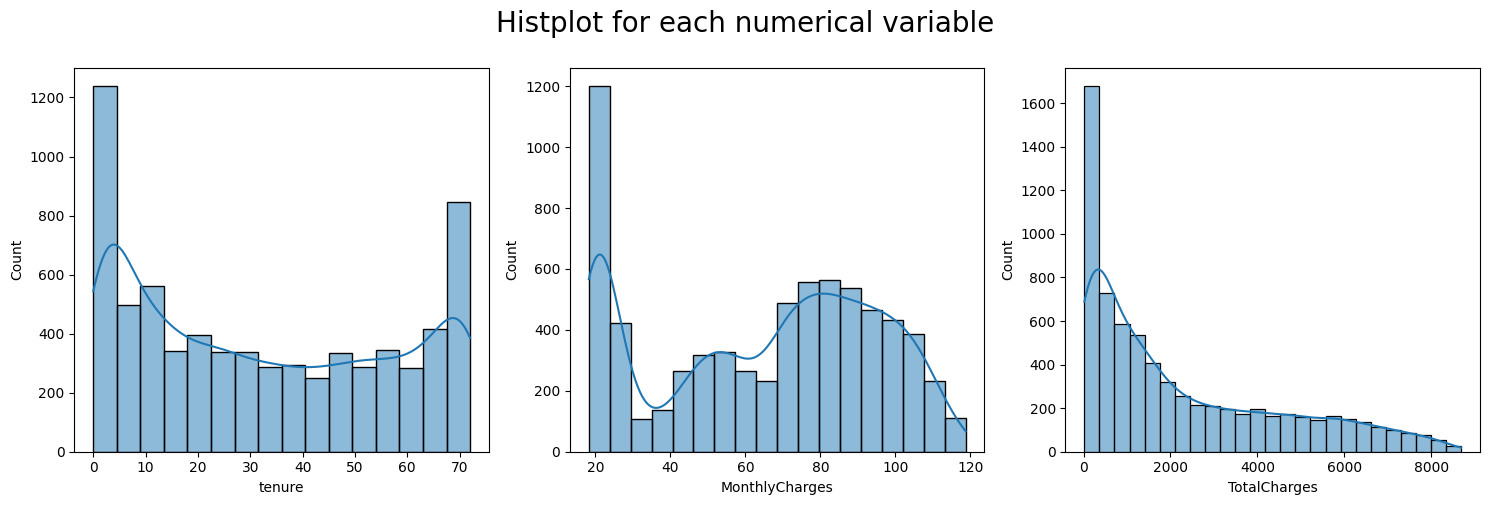

In [58]:
# Histplot for each variable in numerical list
def histplot_visual(data,column):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle('Histplot for each numerical variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.histplot(data=data[feature],ax=ax[i], kde=True)
histplot_visual(data=df,column=numerical_columns)
plt.tight_layout()

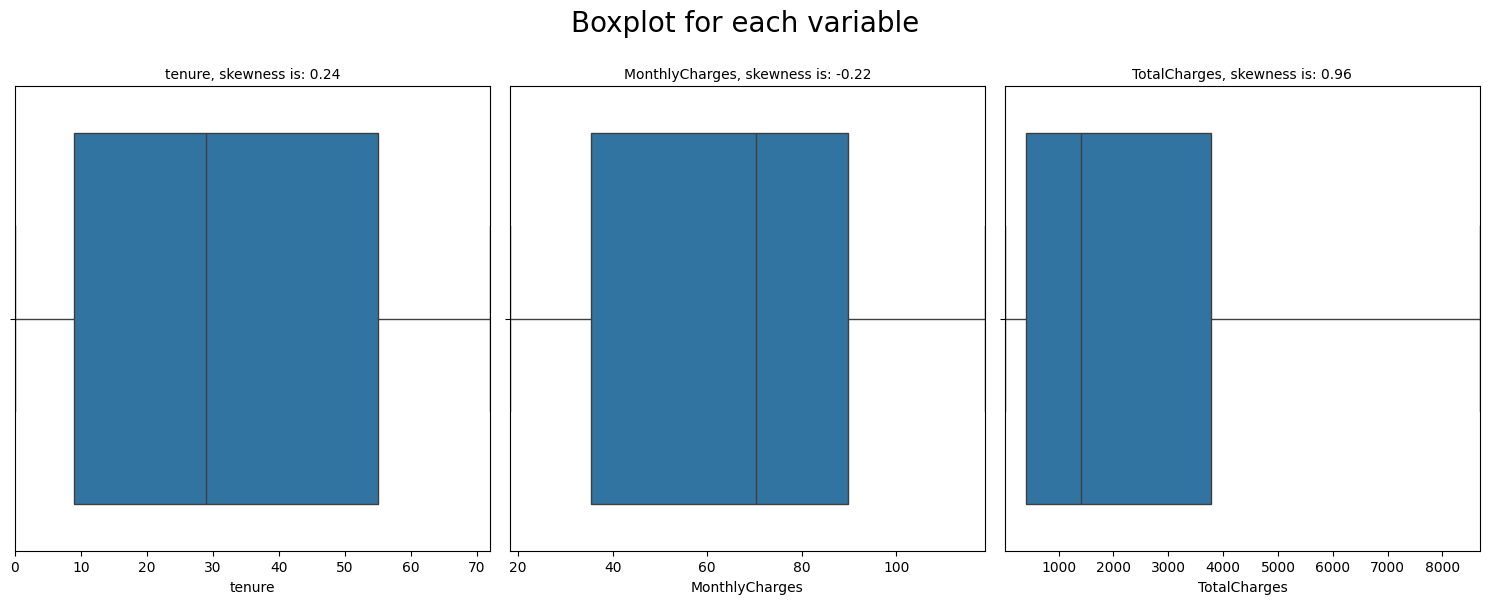

In [59]:
# Boxplot for each variable in numerical list
def boxplots_visual(data,column):
    fig, ax = plt.subplots(1,3,figsize=(15,6))
    fig.suptitle('Boxplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness is: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=10)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])
boxplots_visual(data=df,column=numerical_columns)
plt.tight_layout()

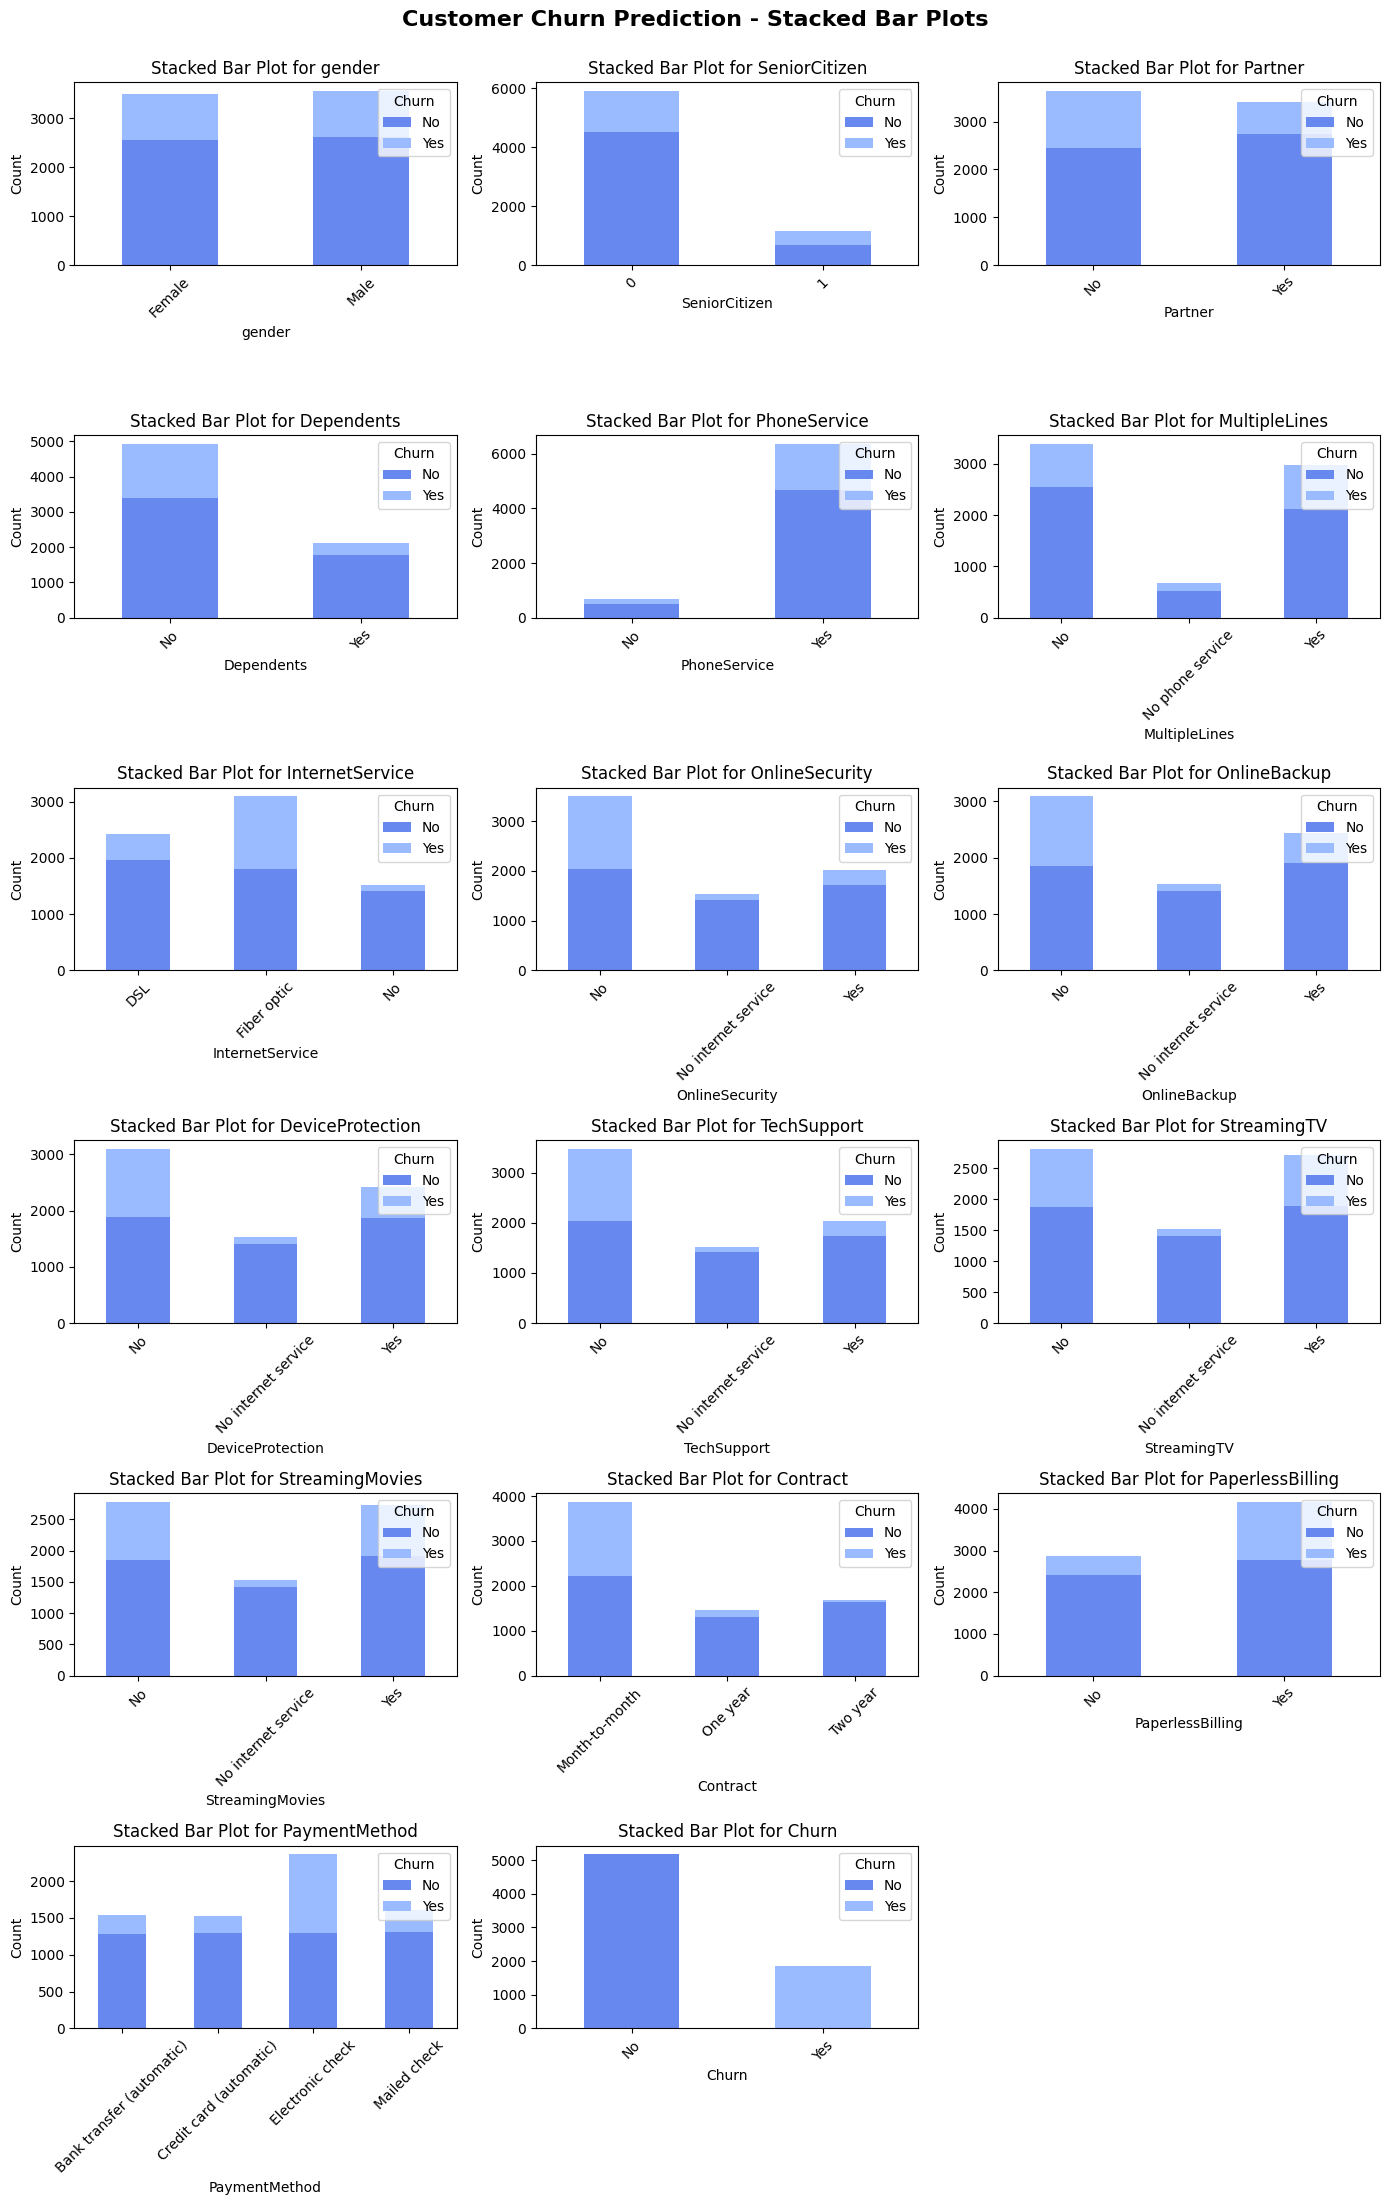

In [60]:
# Create subplots
fig, axes = plt.subplots(6, 3, figsize=(14, 22))

# Flatten axes if necessary
axes = axes.flatten()

# Custom color palette
color_palette = sns.color_palette("coolwarm")

# Loop through object columns and create stacked bar plots
for i, column in enumerate(categorical_columns):
    churn_grouped = df.groupby([column, 'Churn']).size().unstack().fillna(0)
    churn_grouped.plot(kind='bar', stacked=True, ax=axes[i], color=color_palette)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f"Stacked Bar Plot for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    axes[i].legend(title='Churn', loc='upper right')  # Add legend

# Hiding the extra subplots
for j in range(len(categorical_columns), 6 * 3):
    axes[j].axis('off')

# Add main title
plt.suptitle("Customer Churn Prediction - Stacked Bar Plots", fontsize=16, y=1.00, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

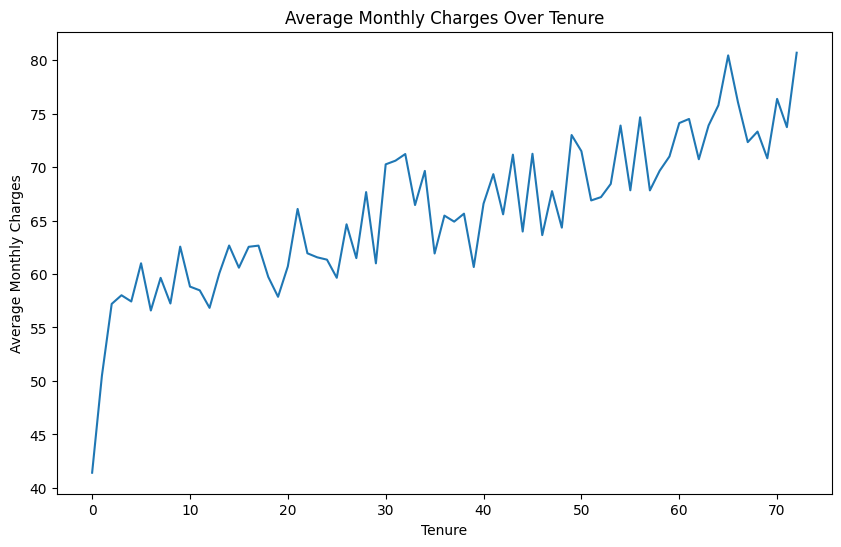

In [61]:
# A line plot for average monthly charges over different tenures
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='tenure', y='MonthlyCharges', errorbar=None)
plt.title("Average Monthly Charges Over Tenure")
plt.xlabel("Tenure")
plt.ylabel("Average Monthly Charges")
plt.show()

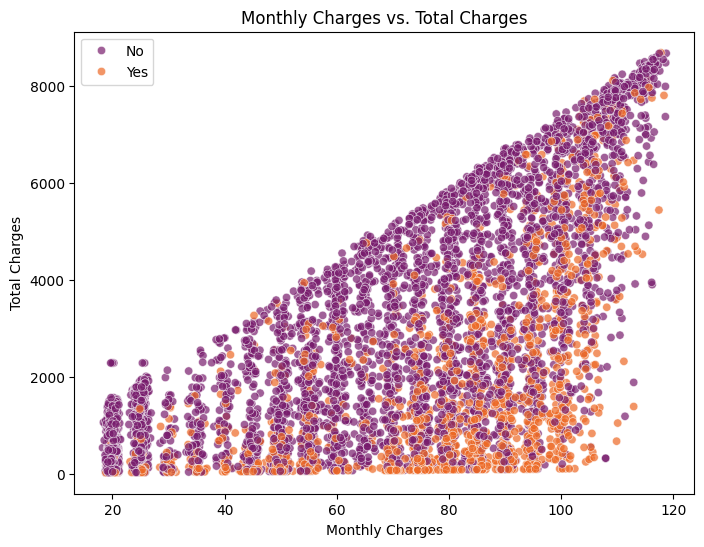

In [62]:
# Scatter plot of MonthlyCharges vs. TotalCharges with respect to Churn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.7, palette= 'inferno')
plt.title("Monthly Charges vs. Total Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Total Charges")
plt.legend()
plt.show()

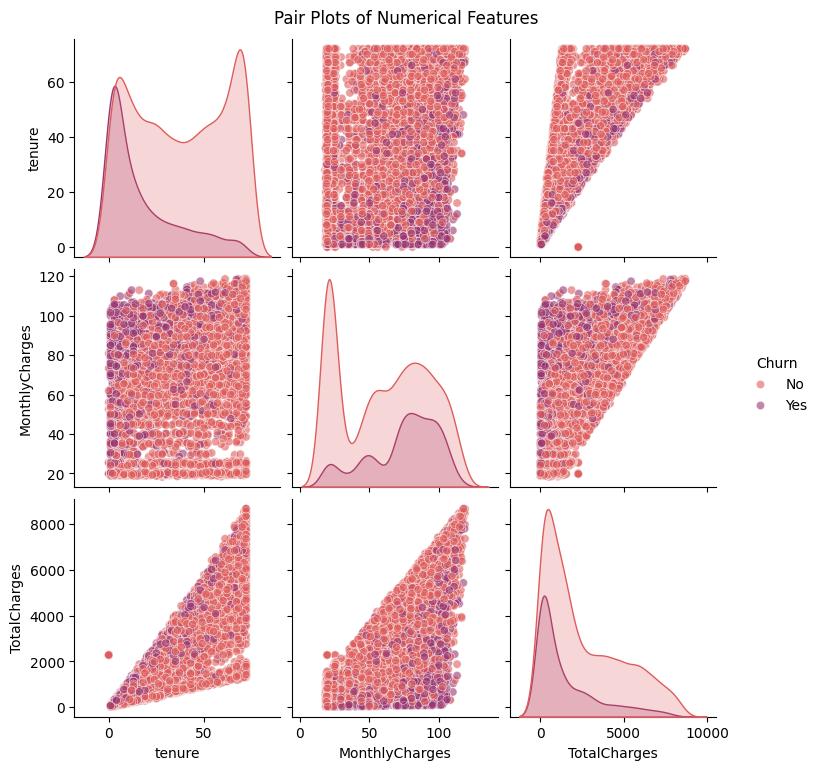

In [63]:
# pair plots for numerical features
subset_columns = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']
sns.pairplot(df[subset_columns], hue='Churn', diag_kind='kde', plot_kws={'alpha': 0.6}, palette= 'flare')
plt.suptitle("Pair Plots of Numerical Features", y=1.02)
plt.show()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


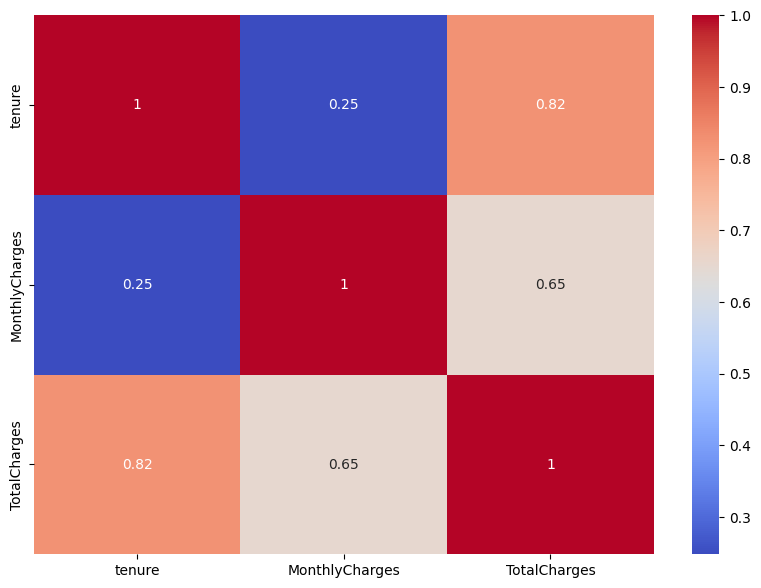

In [65]:
# Plotting a heatmap
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10,7))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.show()

In [66]:
df['SeniorCitizen']= df['SeniorCitizen'].astype('int')

In [67]:
# Mapping columns that have values either "Yes" or "No"
mapping_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for i in mapping_columns:
    df[i] = df[i].map({'No': 0, 'Yes': 1})

In [68]:
# One hot encoding our categorical variable
one_hot_columns = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
df = pd.get_dummies(data=df,columns=one_hot_columns, drop_first= True)
df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   PaperlessBilling                       7043 non-null   int64  
 6   MonthlyCharges                         7043 non-null   float64
 7   TotalCharges                           7043 non-null   float64
 8   Churn                                  7043 non-null   int64  
 9   gender_Male                            7043 non-null   bool   
 10  MultipleLines_No phone service         7043 non-null   bool   
 11  Mult

# Model Training

In [70]:
# Dividing our dataset into independent and dependent features
X=df.drop('Churn',axis=1)
y=df['Churn']

In [71]:
# Splitting our dataset between training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

In [72]:
# MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
# Save the scaler into pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

#### From the count plot we visiualized earlier for "Churn" we can see that it is a case of class imbalance so to handle this imbalancy we need to perform resampling techniques.

In [74]:
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling

#### UnderSampling

In [75]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 3902, 1: 1380})
The number of classes after fit Counter({0: 1380, 1: 1380})


In [76]:
from sklearn.ensemble import RandomForestClassifier
model1=RandomForestClassifier()
model1.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [77]:
# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[508 764]
 [113 376]]


Accuracy Score: 
 0.5019875070982396


Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.40      0.54      1272
           1       0.33      0.77      0.46       489

    accuracy                           0.50      1761
   macro avg       0.57      0.58      0.50      1761
weighted avg       0.68      0.50      0.52      1761



#### Oversampling

In [78]:
os=RandomOverSampler()
X_train_os,y_train_os=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 3902, 1: 1380})
The number of classes after fit Counter({0: 3902, 1: 3902})


In [79]:
model2=RandomForestClassifier()
model2.fit(X_train_os,y_train_os)

RandomForestClassifier()

In [80]:
y_pred=model2.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1072  200]
 [ 212  277]]


Accuracy Score: 
 0.7660420215786485


Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1272
           1       0.58      0.57      0.57       489

    accuracy                           0.77      1761
   macro avg       0.71      0.70      0.71      1761
weighted avg       0.76      0.77      0.77      1761



#### SMOTETomek

In [81]:
st=SMOTETomek()
X_train_st,y_train_st=st.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 3902, 1: 1380})
The number of classes after fit Counter({0: 3701, 1: 3701})


In [82]:
model3=RandomForestClassifier()
model3.fit(X_train_st,y_train_st)

RandomForestClassifier()

In [83]:
y_pred=model3.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[1052  220]
 [ 186  303]]


Accuracy Score: 
 0.7694491766042022


Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1272
           1       0.58      0.62      0.60       489

    accuracy                           0.77      1761
   macro avg       0.71      0.72      0.72      1761
weighted avg       0.77      0.77      0.77      1761



 #### Both "Oversamling" and "SMOTEomek" are giving similar overall result. Here, let's go with SMOTEomek for further model training with different algorithms and after that we will compare them to see which have the best result

In [84]:
# Importing all algorithms that we are going to use
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [85]:
log_reg = LogisticRegression()
rf_clf = RandomForestClassifier()
svc_clf = SVC()
xgb_clf = XGBClassifier()

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "SVC": svc_clf,
    "XGBoost": xgb_clf
}

In [86]:
for name, model in models.items():
    print("MODEL NAME :-", name, "\n")
    model.fit(X_train_st, y_train_st)

    y_pred = model.predict(X_test)
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("Accuracy Score: \n", accuracy_score(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))
    print("-" * 60)

MODEL NAME :- Logistic Regression 

Confusion Matrix: 
 [[897 375]
 [107 382]]
Accuracy Score: 
 0.7262918796138558
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79      1272
           1       0.50      0.78      0.61       489

    accuracy                           0.73      1761
   macro avg       0.70      0.74      0.70      1761
weighted avg       0.79      0.73      0.74      1761

------------------------------------------------------------
MODEL NAME :- Random Forest 

Confusion Matrix: 
 [[1056  216]
 [ 188  301]]
Accuracy Score: 
 0.7705848949460534
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1272
           1       0.58      0.62      0.60       489

    accuracy                           0.77      1761
   macro avg       0.72      0.72      0.72      1761
weighted avg       0.77      0.77      0.77      1761

-----

#### Out of all RandomForestClassifier and XGBClassifier are having the best result out of the other two algorithms and XGBClassifier is comparingly having a slightly better result by a very-very small margin

In [88]:
# Save XGBoost model (best model)
with open("model.pkl", "wb") as f:
    pickle.dump(xgb_clf, f)